In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:77% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=130, precision=5, suppress=True, threshold=np.inf)

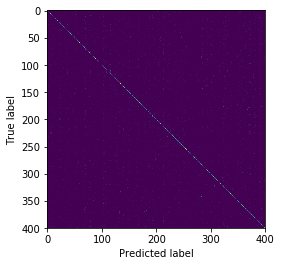

In [13]:
kinetics400_confusion = np.loadtxt('kinetics400_confusion.csv')
cm = kinetics400_confusion
normalize = True
if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest')

In [14]:
label_name_path = '/root/sharedfolder/Research/pose_ad/st-gcn/resource/kinetics_skeleton/label_name.txt'
with open(label_name_path, 'r') as lbl_f:
    lbl_list = lbl_f.read().rstrip().split('\n')

In [15]:
cm_diag = np.diag(cm)
cm_diag_ind_descending = np.argsort(cm_diag)[::-1]
print(cm_diag_ind_descending, cm_diag[134])

[134 254  88  59 336 126 255  75 148   6 260 183 270 208 318 169  77 223 245  19 280 294 305 360 306 339 310 142 399 143 140 161
  43 358 217 356 242 283 315 230 311 330  69 172 346 225 258 348 246 273 166 235  18  99 269 393 375 179 193 182 380 171 253 364
 298 398 147 160  56  44 164 218 202 289 326 153 351  84 275 232 156 302  68 151 234 173 376 365 240 313  31  27  87  30  45 170
 281 262 340 286 250 312  86 323 274 237 378 192 176 221 370 239 303 207 149 243 259 116 321 337 252  15   9 354 267 247 292  55
 301 229 201 268   5 130 341 107 167 137   7 248 367   1 108  66 334 307 349  85 329 309  34 186 244 197  40 119  24 154 162  41
   0 141 214 359 299  22 189  42 343 256 174  57 251 105  20 103 308 146 377 383 199 233 249 352 125 163 104  93 261 159 271  91
 338 333  39  92 387 278 220 219 135 124 335  80  16 178 363 224 395  29 388 277  95  76 180  23 209 241 282 231 332 304 127 350
  28  38   8 227 165 121 131 394 264  70 391 279 285  51  14 168 317  97  32  60 109 296 123 284 

In [16]:
# Sub matrix observing confusions around best performing classes
# We are to evaluate which are the most confused classes for the top performers and consider them for our tests
cm_best_performing = cm[cm_diag_ind_descending[:4]]
cm_bp_most_conf = cm_best_performing.argsort(axis=1)[:, -5:]
cm_bp_most_conf = cm_bp_most_conf[:, ::-1]
uniq_most_conf = np.unique(cm_bp_most_conf[:,1:]) # Removing the classes themselves
np.random.shuffle(uniq_most_conf)
print(cm_bp_most_conf, '\n', uniq_most_conf)

confusing_idx = uniq_most_conf[:10]  # Taking samples from the 10 most confusing classes for our 4 "normal" classes
confusing_idx = [i for i in confusing_idx if i not in [134,254,88,59]]
confusing_idx_list = [lbl_list[i]+str(i) for i in confusing_idx]
confusing_idx_list

[[134  44  88 399 137]
 [254 396 202 303 399]
 [ 88 330 141  20  19]
 [ 59 318 348  88 258]] 
 [ 20 348 318 399 303  88 396  19 141 330 137 202 258  44]


['bending back20',
 'tango dancing348',
 'snatch weight lifting318',
 'zumba399',
 'sign language interpreting303',
 'writing396',
 'bench pressing19',
 'golf chipping141',
 'squat330']

In [17]:
lbl_counts = kinetics400_confusion
lbl_list[134]
# [[i, lbl_list[i]] for i in uniq_most_conf]

'front raises'

In [18]:
import os
import re

In [19]:
data_path = dict()
label_path = dict()
split_indices = dict()
data_npy = dict()
data_pkl = dict()  # An array of [sample_name, label]

In [34]:
data_dir_path = '/root/sharedfolder/datasets/data_ssd/kinetics-skeleton/st-gcn_kinetics/Kinetics/kinetics-skeleton/'
test_data_path = os.path.join(data_dir_path, 'val_data.npy')
test_label_path = os.path.join(data_dir_path, 'val_label.pkl')

test_npy = np.load(test_data_path, mmap_mode='r')
sample_name, label = pickle.load(open(test_label_path, "rb"))

In [53]:
specify_classes = [94,99]
class_indices = [i for i, lbl in enumerate(label) if lbl in specify_classes]
sample_name_cls = [sample_name[i] for i in class_indices]
label_cls = [label[i] for i in class_indices]
data_cls = test_npy[class_indices]

In [60]:
len(data_cls)

100

In [21]:
for split in ['normal_test', 'mixed_test']:
    data_path[split]  =  os.path.join(data_dir_path, 'ad_experiment', split+'_data.npy')
    label_path[split] =  os.path.join(data_dir_path, 'ad_experiment', split+'_label.pkl')

In [22]:
save_files = False
split_npy = test_npy
split_2gen = 'abnormal_test'

In [23]:
# Train Split Generator
data_pkl['abnormal_test'] = [[],[]]  # Important to zero so not to accumulate older values

for split in confusing_idx_list + ['abnormal_test', 'mixed_test']:
    data_path[split]  =  os.path.join(data_dir_path, 'ad_experiment', split+'_data.npy')
    label_path[split] =  os.path.join(data_dir_path, 'ad_experiment', split+'_label.pkl')
    split_num = re.findall('\d+', split)
    if split_num != []:
        split_indices[split] = [ind for ind, val in enumerate(label) if val == int(split_num[0])]
        data_npy[split] = split_npy[split_indices[split]]
        data_pkl[split] = [[sample_name[i] for i in split_indices[split]], [label[i] for i in split_indices[split]]]
        data_pkl[split_2gen][0] += data_pkl[split][0]
        data_pkl[split_2gen][1] += data_pkl[split][1]
        print("Split {}, data_pkl[split][0] len={}, data_pkl[split_2gen][0] len={}".format(split, len(data_pkl[split][0]), len(data_pkl[split_2gen][0])))

data_npy[split_2gen] = np.concatenate([data_npy[split_key] for split_key in confusing_idx_list])

Split bending back20, data_pkl[split][0] len=48, data_pkl[split_2gen][0] len=48
Split tango dancing348, data_pkl[split][0] len=50, data_pkl[split_2gen][0] len=98
Split snatch weight lifting318, data_pkl[split][0] len=49, data_pkl[split_2gen][0] len=147
Split zumba399, data_pkl[split][0] len=45, data_pkl[split_2gen][0] len=192
Split sign language interpreting303, data_pkl[split][0] len=48, data_pkl[split_2gen][0] len=240
Split writing396, data_pkl[split][0] len=50, data_pkl[split_2gen][0] len=290
Split bench pressing19, data_pkl[split][0] len=50, data_pkl[split_2gen][0] len=340
Split golf chipping141, data_pkl[split][0] len=50, data_pkl[split_2gen][0] len=390
Split squat330, data_pkl[split][0] len=50, data_pkl[split_2gen][0] len=440


In [24]:
data_npy[split_2gen].shape

(440, 3, 300, 18, 2)

In [25]:
data_npy['normal_test'] = np.load(data_path['normal_test'], mmap_mode='r')
data_pkl['normal_test'] = pickle.load(open(label_path['normal_test'], "rb"))

In [26]:
data_npy['mixed_test'] = np.concatenate([data_npy[split_key] for split_key in ['normal_test', 'abnormal_test']])
data_pkl['mixed_test'] = [[],[]]  
data_pkl['mixed_test'][0] = data_pkl['normal_test'][0] + data_pkl['abnormal_test'][0]
data_pkl['mixed_test'][1] = data_pkl['normal_test'][1] + data_pkl['abnormal_test'][1]

In [33]:
print('abnormal_test', data_npy['abnormal_test'].shape, len(data_pkl['abnormal_test'][0]))
print('normal_test  ', data_npy['normal_test'  ].shape, len(data_pkl['normal_test'  ][0]))
print('mixed_test   ', data_npy['mixed_test'   ].shape, len(data_pkl['mixed_test'   ][0]))
# print(data_pkl['mixed_test'][1])

abnormal_test (440, 3, 300, 18, 2) 440
normal_test   (198, 3, 300, 18, 2) 198
mixed_test    (638, 3, 300, 18, 2) 638


In [31]:
label_path['mixed_test']

'/root/sharedfolder/datasets/data_ssd/kinetics-skeleton/st-gcn_kinetics/Kinetics/kinetics-skeleton/ad_experiment/mixed_test_label.pkl'

In [30]:
if False:
    np.save(data_path['abnormal_test'], data_npy['abnormal_test'])
    pickle.dump(data_pkl['abnormal_test'], open(label_path['abnormal_test'] ,"wb"))
if False:
    np.save(data_path['mixed_test'], data_npy['mixed_test'])
    pickle.dump(data_pkl['mixed_test'], open(label_path['mixed_test'] ,"wb"))

In [30]:
# Parsing 4-v-all *kinetics pre-trained* results
curr_dir = !pwd
logdir_path = './logs/kinetics_trained_n_v_all/'
logdir = os.listdir(logdir_path)
logdir_dec3 = [fn for fn in logdir if fn.startswith("Dec3")]
full_logdir_dec3 = [os.path.join(curr_dir[0], logdir_path, i) for i in logdir_dec3]
sorted_list = sorted(full_logdir_dec3, key=os.path.getmtime)[7:]
sorted_list = [fp.rstrip('.tx').split('_')[-1] for fp in sorted_list]
sorted_list = [fp.lstrip('auc') for fp in sorted_list]
sorted_list = np.array([int(i) for i in sorted_list])
sorted_list
print(sorted_list.mean(), sorted_list.std())
# Dec31 15:08 got Average AuC of 68.2 +- 7.57

68.19 7.571915213471424
